In [1]:
import pandas as pd

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [5]:
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from pycaret import regression
import seaborn as sns

<AxesSubplot: ylabel='MLM'>

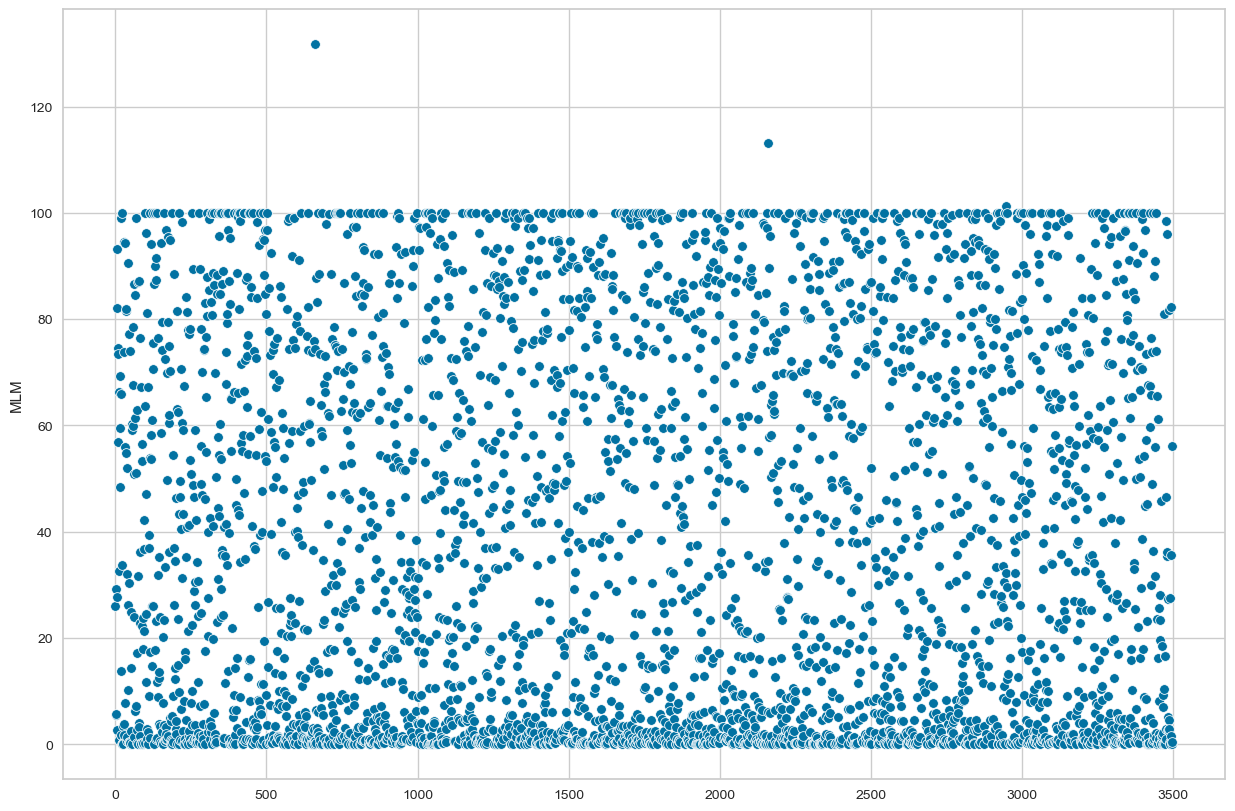

In [7]:
plt.figure(figsize=(15,10))
sns.scatterplot(train['MLM'])

<AxesSubplot: xlabel='HLM', ylabel='Density'>

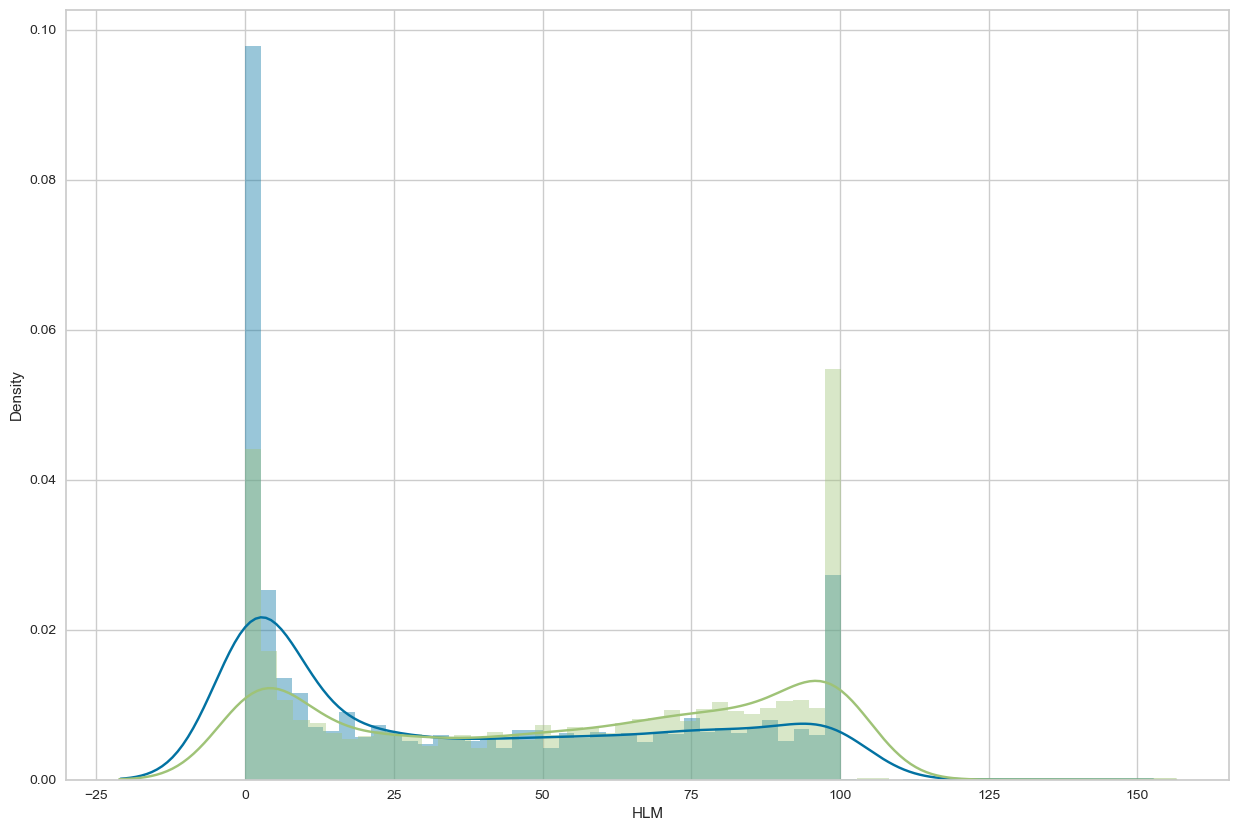

In [16]:
plt.figure(figsize=(15,10))
sns.distplot(train['MLM'],bins=50)
sns.distplot(train['HLM'],bins=50)

<AxesSubplot: >

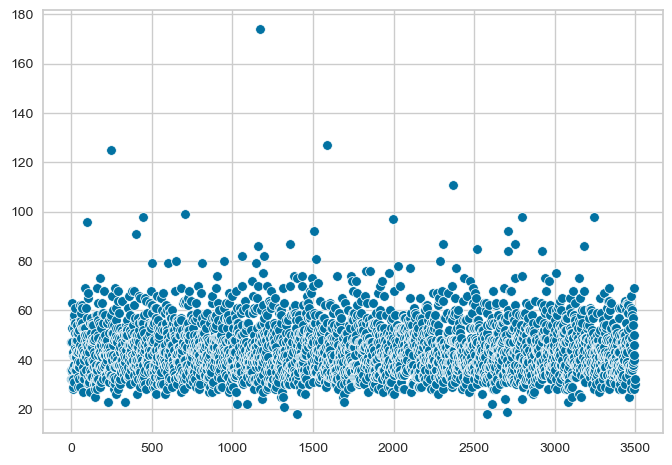

In [44]:
sns.scatterplot([len(i) for i in train.SMILES])

<AxesSubplot: >

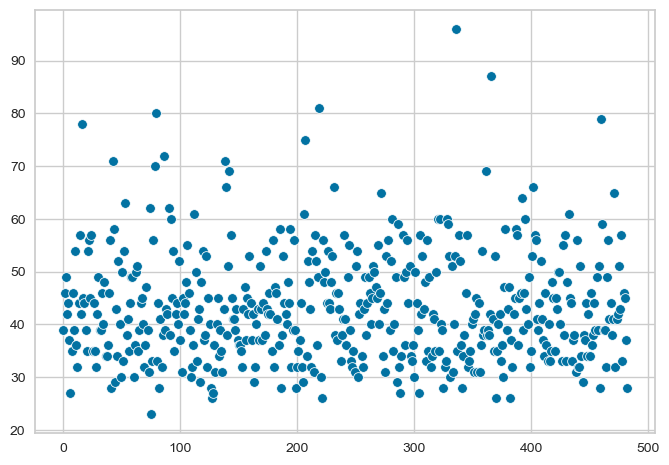

In [45]:
sns.scatterplot([len(i) for i in test.SMILES])

In [19]:
train[train['HLM'] >= 99]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
14,TRAIN_0014,Oc1cc(-c2ccc(-c3ccc(Br)cc3)cc2)nn1-c1ccccn1,69.280,99.000,5.541,392.249,3,1,3,5.539,50.94
22,TRAIN_0022,O=C(C1CC(=O)N(c2n[nH]c3cc(Br)ccc23)C1)N1CCCC1,99.900,99.900,1.907,377.236,3,1,2,1.907,69.30
27,TRAIN_0027,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@H](O)C2,73.730,99.000,2.021,290.268,6,5,1,2.010,110.38
29,TRAIN_0029,CC(C)Cn1c(NCCN(C)C)nc2c1c(=O)[nH]c(=O)n2C,94.600,99.000,1.375,308.379,4,2,6,-0.111,82.50
...,...,...,...,...,...,...,...,...,...,...,...
3422,TRAIN_3422,Cc1cc(NNS(=O)(=O)c2cccs2)n2ncnc2n1,99.990,99.990,1.358,310.355,5,2,4,1.358,137.89
3442,TRAIN_3442,CC(C)n1c(=O)c2cn(S(=O)(=O)c3ccc(C4CCCCC4)cc3)n...,99.990,99.990,4.960,458.574,5,0,5,4.958,100.95
3448,TRAIN_3448,COc1ccc(-c2nc(-c3ccc(C)cc3)no2)c(OC)c1,65.560,99.990,3.598,296.321,4,0,4,3.598,57.38
3471,TRAIN_3471,COc1ccccc1-n1nc2c(C)nnc(C)c2c1C,81.044,99.833,2.469,268.314,4,0,2,2.545,52.83


<AxesSubplot: ylabel='LogD'>

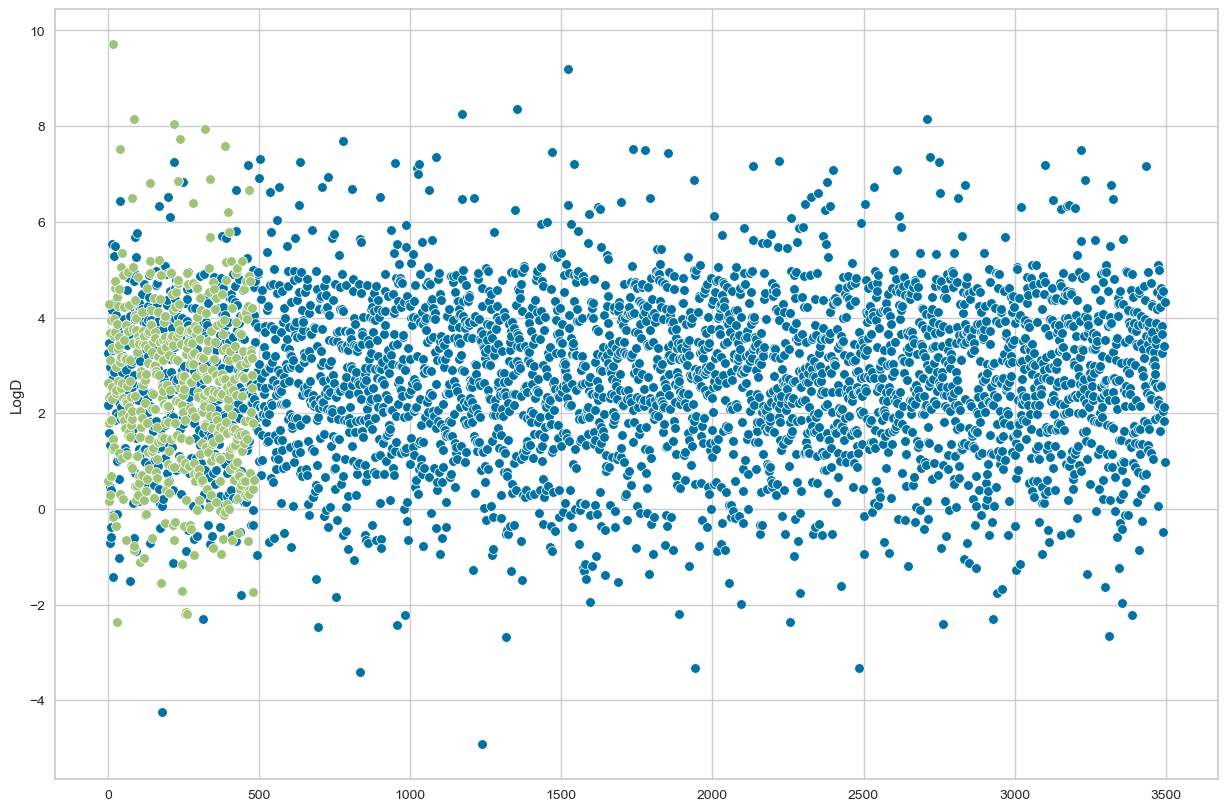

In [24]:
plt.figure(figsize=(15,10))
sns.scatterplot(train['LogD'])
sns.scatterplot(test['LogD'])

In [27]:
train[train['LogD'] < -4]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
179,TRAIN_0179,CCC(CN1CCN(C)CC1)NC(=O)Cc1csc(Nc2ccccc2F)n1,62.030,50.590,-4.137,597.656,11,6,13,-4.241,220.86
1239,TRAIN_1239,c1ccc(-c2cc(CNCC3COCCO3)c3nnnn3c2)cc1,69.077,48.075,-3.761,517.489,13,5,10,-4.920,205.69


Text(0, 0.5, 'HLM')

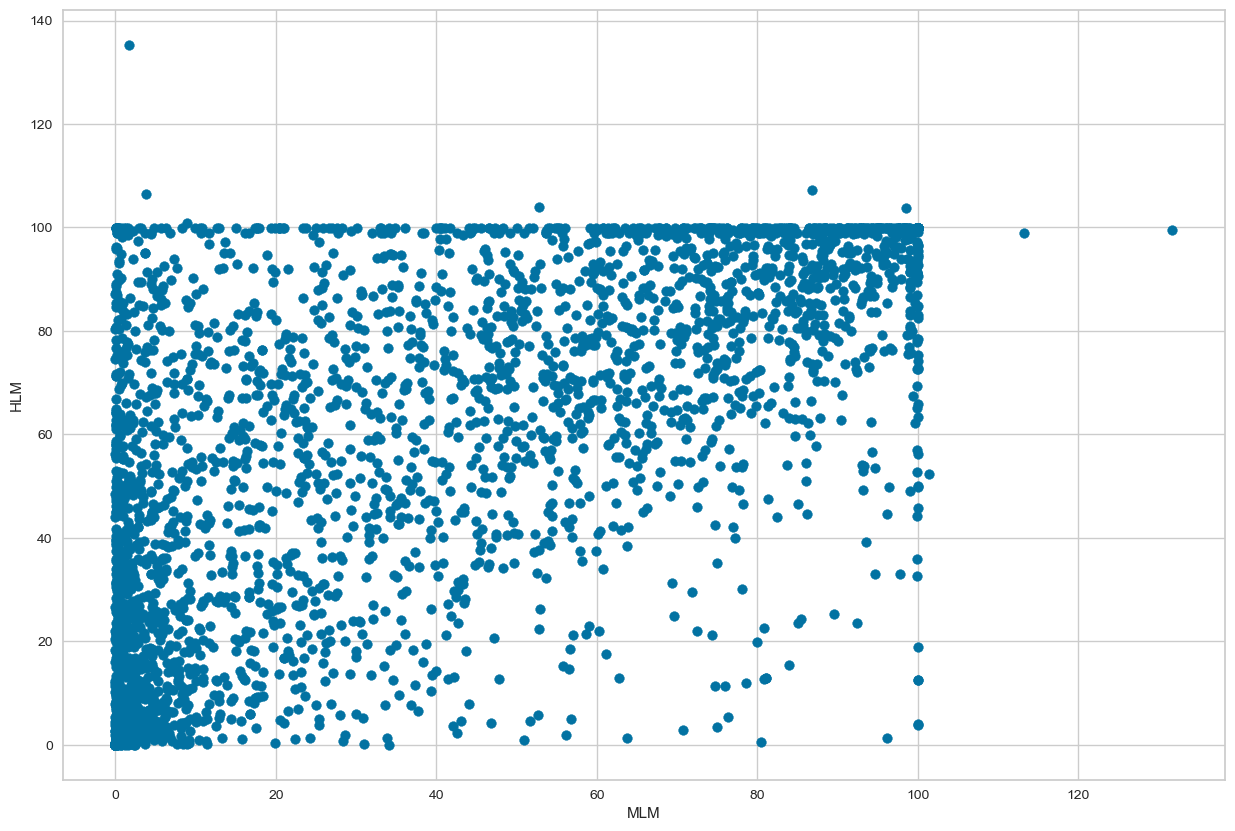

In [41]:
plt.figure(figsize=(15,10))
plt.scatter(train['MLM'],train['HLM'])
plt.xlabel('MLM')
plt.ylabel('HLM')

In [37]:
train[(train['MLM'] > 50) & (train['HLM'] < 50)]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
10,TRAIN_0010,CN(C1CCNCC1)S(=O)(=O)c1ccc(Cl)s1,56.900,40.158,0.767,294.821,3,1,3,0.388,86.03
46,TRAIN_0046,COc1c(Br)ccc2c1sc1ncnc(NC(C)C(=O)O)c12,77.245,39.943,3.357,382.232,5,2,4,1.943,112.58
56,TRAIN_0056,COC(=O)C1C(C(=O)OC)C2(OC(c3ccccc3)=CC2=O)C12OC...,60.227,22.004,2.370,460.432,8,0,6,2.370,105.20
87,TRAIN_0087,O=c1ccc(-c2ccc(S(=O)(=O)NCc3cccc(Br)c3)s2)n[nH]1,56.540,14.710,2.768,426.308,4,2,5,2.808,124.24
88,TRAIN_0088,[H][C@]1(NC(=O)OCc2ccccc2)C2C=CC(C2)[C@@]1([H]...,53.390,38.995,4.908,425.519,3,2,7,4.908,58.56
...,...,...,...,...,...,...,...,...,...,...,...
3225,TRAIN_3225,CC(C)Cn1cc(NC(=O)NC2CCN(Cc3ccccc3)CC2)c2ccccc2...,58.980,48.040,2.639,432.558,3,2,6,2.613,64.68
3327,TRAIN_3327,Cc1ccsc1CN(Cc1cn2ccccc2c1C#N)C(C)C,57.910,46.830,4.014,323.455,2,0,5,2.434,59.67
3426,TRAIN_3426,COc1cc(Cn2c(=O)[nH]c(O)c(C(C)=O)c2=O)cc(OC)c1,76.400,5.280,0.874,320.297,6,2,5,0.717,105.17
3451,TRAIN_3451,Fc1cn/c(=N/c2ccccc2Cl)[nH]c1Nc1ccccc1Cl,61.131,17.568,4.835,349.190,2,2,3,4.731,48.78


In [38]:
len(train)

3498

In [39]:
690*4

2760

In [123]:
train = pd.read_csv('./train.csv')
train = train.groupby('SMILES').mean().reset_index()
train['Molecular_Weight'] = [Descriptors.MolWt(Chem.MolFromSmiles(i)) for i in train['SMILES']]
train['Numbond'] = [Chem.MolFromSmiles(i).GetNumBonds() for i in train['SMILES']]
train['HeavyAtoms'] = [Chem.MolFromSmiles(i).GetNumHeavyAtoms() for i in train['SMILES']]
train['AlogP'] = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in train['SMILES']]


droping = []
tp = pd.DataFrame(train['SMILES'].str.contains('e'))
droping.extend(list(tp[tp['SMILES'] == True].index))
tp = pd.DataFrame(train['SMILES'].str.contains('I'))
droping.extend(list(tp[tp['SMILES'] == True].index))
tp = pd.DataFrame(train['SMILES'].str.contains('6'))
droping.extend(list(tp[tp['SMILES'] == True].index))
train = train.drop(droping)

# PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
# PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')
# def mol2fp(mol):
#     fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=64)
#     ar = np.zeros((1,), dtype=np.int8)
#     DataStructs.ConvertToNumpyArray(fp, ar)
#     return ar

# train["FPs"] = train.Molecule.apply(mol2fp)
# test["FPs"] = test.Molecule.apply(mol2fp)


mlm_train = train.drop(['SMILES','HLM'],axis=1)
hlm_train = train.drop(['SMILES','MLM'],axis=1)
train = train.reset_index(drop=True)

In [127]:
mlm_train = pd.concat([mlm_train,pd.DataFrame([list(i) for i in train.FPs])],axis=1)
mlm_train = mlm_train.dropna()
mlm_train = mlm_train.reset_index(drop=True)
mlm_train = mlm_train.drop(['FPs','Molecule'],axis=1)

In [120]:
# mlm_train = mlm_train.loc[:,['MLM','Molecular_Weight','AlogP','LogD','Molecular_PolarSurfaceArea']]

In [94]:
hlm_train = pd.concat([hlm_train,pd.DataFrame([list(i) for i in train.FPs])],axis=1)
hlm_train = hlm_train.dropna()
hlm_train = hlm_train.reset_index(drop=True)
hlm_train = hlm_train.drop(['FPs','Molecule'],axis=1)

In [116]:
test['Molecular_Weight'] = [Descriptors.MolWt(Chem.MolFromSmiles(i)) for i in test['SMILES']]
test['Numbond'] = [Chem.MolFromSmiles(i).GetNumBonds() for i in test['SMILES']]
test['HeavyAtoms'] = [Chem.MolFromSmiles(i).GetNumHeavyAtoms() for i in test['SMILES']]

smiles = test['SMILES'][10]
mol = Chem.MolFromSmiles(smiles)
alogp = Descriptors.MolLogP(mol)
test['AlogP'][10] = alogp
test['AlogP'] = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in test['SMILES']]

# test = pd.concat([test,pd.DataFrame([list(i) for i in test.FPs])],axis=1)
# test = test.drop(['id','SMILES','Molecule','FPs'],axis=1)
# test = test.astype('float64')
# test.columns = [str(i) for i in test.columns]

In [6]:
mlm_train = pd.read_csv('./mlm_train.csv').drop('Unnamed: 0',axis=1)
mlm_train = mlm_train.drop(['id','SMILES','HLM'],axis=1)

In [8]:
regression.setup(data=mlm_train,target='MLM',
                 fold_strategy='kfold',
                 fold=5,
                 session_id=42)

best = regression.compare_models(sort='RMSE',n_select=5)

,Description,Value
0,Session id,42
1,Target,MLM
2,Target type,Regression
3,Original data shape,"(2731, 234)"
4,Transformed data shape,"(2731, 234)"
5,Transformed train set shape,"(1911, 234)"
6,Transformed test set shape,"(820, 234)"
7,Numeric features,233
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,17.0720,467.9267,21.5978,0.5582,1.3200,33.4029,5.6940
et,Extra Trees Regressor,17.7347,493.6049,22.1947,0.5338,1.3467,36.2906,4.6640
lightgbm,Light Gradient Boosting Machine,17.4547,500.9752,22.3554,0.5268,1.3215,33.7205,3.8980
gbr,Gradient Boosting Regressor,17.9314,505.1463,22.4548,0.5228,1.3816,40.3878,4.0300
rf,Random Forest Regressor,18.0491,514.8429,22.6649,0.5131,1.3585,38.2332,4.8980
xgboost,Extreme Gradient Boosting,17.6826,525.7698,22.8750,0.5031,1.3344,35.9882,3.9360
br,Bayesian Ridge,20.4727,621.5683,24.9188,0.4128,1.4787,45.5012,3.6980
omp,Orthogonal Matching Pursuit,20.8630,655.3908,25.5918,0.3805,1.4888,47.5270,3.7080
ridge,Ridge Regression,20.8646,672.2597,25.9037,0.3656,1.4771,47.8832,3.7660
lasso,Lasso Regression,21.4389,672.9589,25.9327,0.3640,1.5265,52.6658,3.6680


In [9]:
# best_tune = [regression.tune_model(i,fold=10) for i in best]

In [12]:
test = pd.read_csv('./data_t.csv').drop(['Unnamed: 0'],axis=1)
mlm = [i.predict(test) for i in best]

In [104]:
# test = pd.read_csv('./test.csv')
# test['Molecular_Weight'] = [Descriptors.MolWt(Chem.MolFromSmiles(i)) for i in test['SMILES']]
# test['Numbond'] = [Chem.MolFromSmiles(i).GetNumBonds() for i in test['SMILES']]
# test['HeavyAtoms'] = [Chem.MolFromSmiles(i).GetNumHeavyAtoms() for i in test['SMILES']]

# smiles = test['SMILES'][10]
# mol = Chem.MolFromSmiles(smiles)
# alogp = Descriptors.MolLogP(mol)
# test['AlogP'][10] = alogp
# test['AlogP'] = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in test['SMILES']]

# test = test.drop(['id','SMILES'],axis=1)

# mlm = [i.predict(test) for i in best_tune]
# pred_mlm = np.array(mlm).mean(axis=0)

In [16]:
hlm_train = pd.read_csv('./hlm_train.csv').drop('Unnamed: 0',axis=1)
hlm_train = hlm_train.drop(['id','SMILES','MLM'],axis=1)

In [17]:
# train = pd.read_csv('./train.csv')
# train = train.groupby('SMILES').mean().reset_index()
# train['Molecular_Weight'] = [Descriptors.MolWt(Chem.MolFromSmiles(i)) for i in train['SMILES']]
# train['Numbond'] = [Chem.MolFromSmiles(i).GetNumBonds() for i in train['SMILES']]
# train['HeavyAtoms'] = [Chem.MolFromSmiles(i).GetNumHeavyAtoms() for i in train['SMILES']]
# train['AlogP'] = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in train['SMILES']]


# droping = []
# tp = pd.DataFrame(train['SMILES'].str.contains('e'))
# droping.extend(list(tp[tp['SMILES'] == True].index))
# tp = pd.DataFrame(train['SMILES'].str.contains('I'))
# droping.extend(list(tp[tp['SMILES'] == True].index))
# tp = pd.DataFrame(train['SMILES'].str.contains('6'))
# droping.extend(list(tp[tp['SMILES'] == True].index))
# droping
# train = train.drop(droping)


# hlm_train = train.drop(['SMILES','MLM'],axis=1)

regression.setup(data=hlm_train,target='HLM',
                 fold_strategy='kfold',
                 fold=5,
                 session_id=42)

best = regression.compare_models(sort='RMSE',n_select=5)

,Description,Value
0,Session id,42
1,Target,HLM
2,Target type,Regression
3,Original data shape,"(2627, 234)"
4,Transformed data shape,"(2627, 234)"
5,Transformed train set shape,"(1838, 234)"
6,Transformed test set shape,"(789, 234)"
7,Numeric features,233
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,19.1334,545.9922,23.3454,0.5241,1.0172,10.1321,5.4340
gbr,Gradient Boosting Regressor,19.6907,571.2614,23.8920,0.5023,1.0609,11.8590,4.0360
lightgbm,Light Gradient Boosting Machine,19.3243,573.2694,23.9232,0.5003,1.0184,13.1863,3.7780
et,Extra Trees Regressor,20.0311,585.2669,24.1799,0.4899,1.0557,12.1216,4.5500
rf,Random Forest Regressor,20.0221,593.1420,24.3387,0.4829,1.0587,12.7246,4.6460
xgboost,Extreme Gradient Boosting,20.0891,620.1301,24.8811,0.4588,1.0318,11.8840,4.0720
ada,AdaBoost Regressor,22.5236,688.5688,26.2357,0.4010,1.1804,17.7237,3.6480
br,Bayesian Ridge,22.0623,698.8243,26.4168,0.3921,1.1324,12.9605,3.7220
omp,Orthogonal Matching Pursuit,22.5967,741.3471,27.2052,0.3553,1.1379,12.6998,3.6700
lasso,Lasso Regression,22.7756,744.9527,27.2796,0.3521,1.1681,15.3613,3.7200


In [18]:
# best_tune = [regression.tune_model(i,fold=10) for i in best]

In [20]:
hlm = [i.predict(test) for i in best]

In [13]:
# test = pd.read_csv('./test.csv')
# test['Molecular_Weight'] = [Descriptors.MolWt(Chem.MolFromSmiles(i)) for i in test['SMILES']]
# test['Numbond'] = [Chem.MolFromSmiles(i).GetNumBonds() for i in test['SMILES']]
# test['HeavyAtoms'] = [Chem.MolFromSmiles(i).GetNumHeavyAtoms() for i in test['SMILES']]

# smiles = test['SMILES'][10]
# mol = Chem.MolFromSmiles(smiles)
# alogp = Descriptors.MolLogP(mol)
# test['AlogP'][10] = alogp

# test['AlogP'] = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in test['SMILES']]

# test = test.drop(['id','SMILES'],axis=1)

# hlm = [i.predict(test) for i in best]
# pred_hlm = np.array(hlm).mean(axis=0)

In [51]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(n_estimators=1000,random_seed=42,max_depth=12,loss_function='RMSE')
cat.fit(hlm_train.drop('HLM',axis=1),hlm_train['HLM'],verbose=500)
pred_hlm_cat = cat.predict(test)

from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators=1000,random_seed=42,learning_rate=0.001,verbose=500,max_depth=12,loss_function='RMSE')
lgb.fit(hlm_train.drop('HLM',axis=1),hlm_train['HLM'])
pred_hlm_lgb = lgb.predict(test)

from xgboost import XGBRegressor
xgb = XGBRegressor(random_seed=42,n_estimators=1000,loss_function='RMSE',verbose=1000,max_depth=12)
xgb.fit(hlm_train.drop('HLM',axis=1),hlm_train['HLM'])
pred_hlm_xgb = xgb.predict(test)

Learning rate set to 0.047693
0:	learn: 33.2486062	total: 74.9ms	remaining: 1m 14s
500:	learn: 5.6845167	total: 40.4s	remaining: 40.2s
999:	learn: 1.6670106	total: 1m 20s	remaining: 0us
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.915986
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.831793
[LightGBM] [Debug] init for col-wise cost 0.001397 seconds, init for row-wise cost 0.002031 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug

In [52]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(n_estimators=500,random_seed=42,max_depth=12,loss_function='RMSE')
cat.fit(mlm_train.drop('MLM',axis=1),mlm_train['MLM'],verbose=500)
pred_mlm_cat = cat.predict(test)

from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators=500,random_seed=42,learning_rate=0.001,verbose=500,max_depth=12,loss_function='RMSE')
lgb.fit(mlm_train.drop('MLM',axis=1),mlm_train['MLM'])
pred_mlm_lgb = lgb.predict(test)

from xgboost import XGBRegressor
xgb = XGBRegressor(random_seed=42,n_estimators=500,loss_function='RMSE',verbose=1000,max_depth=12)
xgb.fit(mlm_train.drop('MLM',axis=1),mlm_train['MLM'])
pred_mlm_xgb = xgb.predict(test)

Learning rate set to 0.047986
0:	learn: 31.7702937	total: 86.9ms	remaining: 1m 26s
500:	learn: 6.5321403	total: 41.9s	remaining: 41.7s
999:	learn: 2.0012318	total: 1m 24s	remaining: 0us
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.915657
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.831675
[LightGBM] [Debug] init for col-wise cost 0.001850 seconds, init for row-wise cost 0.001850 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trai

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debu

[05:13:46] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "loss_function", "random_seed", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
# pred_mlm = np.array(mlm).mean(axis=0)
# pred_hlm = np.array(hlm).mean(axis=0)

In [53]:
sub = pd.read_csv('./sample_submission.csv')
sub['MLM'] = 0.5*pred_mlm_cat + 0.3*pred_mlm_lgb + 0.2*pred_mlm_xgb
sub['HLM'] = 0.5*pred_hlm_cat + 0.3*pred_hlm_lgb + 0.2*pred_hlm_xgb
sub = sub.set_index('id')
sub.to_csv('./submission.csv')

In [1]:
import sys
sys.path.append("C:/Users/User/Desktop/git_repo/my_proj/pythonProject/dacon/smiles/SMILESenumeration")
import SmilesEnumerator

In [5]:
sme = SmilesEnumerator.SmilesEnumerator()
print(help(SmilesEnumerator))

Help on module SmilesEnumerator:

NAME
    SmilesEnumerator - #Experimental Class for Smiles Enumeration, Iterator and SmilesIterator adapted from Keras 1.2.2

CLASSES
    builtins.object
        Iterator
            SmilesIterator
        SmilesEnumerator
    
    class Iterator(builtins.object)
     |  Iterator(n, batch_size, shuffle, seed)
     |  
     |  Abstract base class for data iterators.
     |  
     |  # Arguments
     |      n: Integer, total number of samples in the dataset to loop over.
     |      batch_size: Integer, size of a batch.
     |      shuffle: Boolean, whether to shuffle the data between epochs.
     |      seed: Random seeding for data shuffling.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, n, batch_size, shuffle, seed)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  __iter__(self)
     |  
     |  __next__(self, *args, **kwargs)
     |  
     |  reset(self)
     |  
     |  ------------

In [26]:
pd.read_csv('./train.csv')

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51


In [22]:
import pandas as pd
train = pd.read_csv('./train.csv')
ans = []
for smile in train.SMILES:
    for i in range(3):
        ans.append(sme.randomize_smiles(smile))
        
pd.DataFrame(ans,columns=['SMILES']).to_csv('./train_aug.csv')

In [30]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# SMILES 문자열로부터 분자 객체 생성
smiles = "CCO"  # 분석하려는 분자의 SMILES 문자열
mol = Chem.MolFromSmiles(smiles)

train_aug = pd.read_csv('./train_aug.csv')
# 분자량 측정
for mol in train_aug['SMILES']:
    mol = Chem.MolFromSmiles(mol)
    if mol is not None:
        molecular_weight = Descriptors.MolWt(mol)
        print(f"The molecular weight of the molecule is {molecular_weight:.2f} g/mol")
    else:
        print("Invalid SMILES string. Unable to calculate molecular weight.")



The molecular weight of the molecule is 400.50 g/mol
The molecular weight of the molecule is 400.50 g/mol
The molecular weight of the molecule is 400.50 g/mol
The molecular weight of the molecule is 301.42 g/mol
The molecular weight of the molecule is 301.41 g/mol
The molecular weight of the molecule is 301.42 g/mol
The molecular weight of the molecule is 297.37 g/mol
The molecular weight of the molecule is 297.37 g/mol
The molecular weight of the molecule is 297.37 g/mol
The molecular weight of the molecule is 494.67 g/mol
The molecular weight of the molecule is 494.67 g/mol
The molecular weight of the molecule is 494.67 g/mol
The molecular weight of the molecule is 268.32 g/mol
The molecular weight of the molecule is 268.32 g/mol
The molecular weight of the molecule is 268.32 g/mol
The molecular weight of the molecule is 419.43 g/mol
The molecular weight of the molecule is 419.43 g/mol
The molecular weight of the molecule is 419.43 g/mol
The molecular weight of the molecule is 366.40

The molecular weight of the molecule is 445.91 g/mol
The molecular weight of the molecule is 307.36 g/mol
The molecular weight of the molecule is 307.36 g/mol
The molecular weight of the molecule is 307.36 g/mol
The molecular weight of the molecule is 305.16 g/mol
The molecular weight of the molecule is 305.16 g/mol
The molecular weight of the molecule is 305.16 g/mol
The molecular weight of the molecule is 369.56 g/mol
The molecular weight of the molecule is 369.56 g/mol
The molecular weight of the molecule is 369.56 g/mol
The molecular weight of the molecule is 379.64 g/mol
The molecular weight of the molecule is 379.64 g/mol
The molecular weight of the molecule is 379.64 g/mol
The molecular weight of the molecule is 418.45 g/mol
The molecular weight of the molecule is 418.45 g/mol
The molecular weight of the molecule is 418.45 g/mol
The molecular weight of the molecule is 337.42 g/mol
The molecular weight of the molecule is 337.42 g/mol
The molecular weight of the molecule is 337.42

The molecular weight of the molecule is 354.19 g/mol
The molecular weight of the molecule is 354.19 g/mol
The molecular weight of the molecule is 354.19 g/mol
The molecular weight of the molecule is 299.40 g/mol
The molecular weight of the molecule is 299.40 g/mol
The molecular weight of the molecule is 299.40 g/mol
The molecular weight of the molecule is 286.29 g/mol
The molecular weight of the molecule is 286.29 g/mol
The molecular weight of the molecule is 286.29 g/mol
The molecular weight of the molecule is 410.46 g/mol
The molecular weight of the molecule is 410.46 g/mol
The molecular weight of the molecule is 410.46 g/mol
The molecular weight of the molecule is 531.64 g/mol
The molecular weight of the molecule is 531.64 g/mol
The molecular weight of the molecule is 531.64 g/mol
The molecular weight of the molecule is 300.36 g/mol
The molecular weight of the molecule is 300.36 g/mol
The molecular weight of the molecule is 300.36 g/mol
The molecular weight of the molecule is 282.34

The molecular weight of the molecule is 279.34 g/mol
The molecular weight of the molecule is 279.34 g/mol
The molecular weight of the molecule is 279.34 g/mol
The molecular weight of the molecule is 264.29 g/mol
The molecular weight of the molecule is 264.29 g/mol
The molecular weight of the molecule is 264.29 g/mol
The molecular weight of the molecule is 326.47 g/mol
The molecular weight of the molecule is 326.47 g/mol
The molecular weight of the molecule is 326.47 g/mol
The molecular weight of the molecule is 447.53 g/mol
The molecular weight of the molecule is 447.53 g/mol
The molecular weight of the molecule is 447.53 g/mol
The molecular weight of the molecule is 437.57 g/mol
The molecular weight of the molecule is 437.57 g/mol
The molecular weight of the molecule is 437.57 g/mol
The molecular weight of the molecule is 252.36 g/mol
The molecular weight of the molecule is 252.36 g/mol
The molecular weight of the molecule is 252.36 g/mol
The molecular weight of the molecule is 548.62

The molecular weight of the molecule is 252.30 g/mol
The molecular weight of the molecule is 344.42 g/mol
The molecular weight of the molecule is 344.42 g/mol
The molecular weight of the molecule is 344.42 g/mol
The molecular weight of the molecule is 287.36 g/mol
The molecular weight of the molecule is 287.36 g/mol
The molecular weight of the molecule is 287.36 g/mol
The molecular weight of the molecule is 291.35 g/mol
The molecular weight of the molecule is 291.35 g/mol
The molecular weight of the molecule is 291.35 g/mol
The molecular weight of the molecule is 430.35 g/mol
The molecular weight of the molecule is 430.35 g/mol
The molecular weight of the molecule is 430.35 g/mol
The molecular weight of the molecule is 511.99 g/mol
The molecular weight of the molecule is 511.99 g/mol
The molecular weight of the molecule is 511.99 g/mol
The molecular weight of the molecule is 298.16 g/mol
The molecular weight of the molecule is 298.17 g/mol
The molecular weight of the molecule is 298.17

The molecular weight of the molecule is 354.52 g/mol
The molecular weight of the molecule is 295.45 g/mol
The molecular weight of the molecule is 295.45 g/mol
The molecular weight of the molecule is 295.45 g/mol
The molecular weight of the molecule is 267.37 g/mol
The molecular weight of the molecule is 267.37 g/mol
The molecular weight of the molecule is 267.37 g/mol
The molecular weight of the molecule is 321.38 g/mol
The molecular weight of the molecule is 321.38 g/mol
The molecular weight of the molecule is 321.38 g/mol
The molecular weight of the molecule is 261.28 g/mol
The molecular weight of the molecule is 261.28 g/mol
The molecular weight of the molecule is 261.28 g/mol
The molecular weight of the molecule is 330.45 g/mol
The molecular weight of the molecule is 330.45 g/mol
The molecular weight of the molecule is 330.45 g/mol
The molecular weight of the molecule is 326.44 g/mol
The molecular weight of the molecule is 326.44 g/mol
The molecular weight of the molecule is 326.44

The molecular weight of the molecule is 586.69 g/mol
The molecular weight of the molecule is 586.69 g/mol
The molecular weight of the molecule is 586.69 g/mol
The molecular weight of the molecule is 402.50 g/mol
The molecular weight of the molecule is 402.50 g/mol
The molecular weight of the molecule is 402.50 g/mol
The molecular weight of the molecule is 371.44 g/mol
The molecular weight of the molecule is 371.44 g/mol
The molecular weight of the molecule is 371.44 g/mol
The molecular weight of the molecule is 386.48 g/mol
The molecular weight of the molecule is 386.48 g/mol
The molecular weight of the molecule is 386.48 g/mol
The molecular weight of the molecule is 367.45 g/mol
The molecular weight of the molecule is 367.45 g/mol
The molecular weight of the molecule is 367.45 g/mol
The molecular weight of the molecule is 369.53 g/mol
The molecular weight of the molecule is 369.53 g/mol
The molecular weight of the molecule is 369.53 g/mol
The molecular weight of the molecule is 303.32

The molecular weight of the molecule is 473.59 g/mol
The molecular weight of the molecule is 473.59 g/mol
The molecular weight of the molecule is 473.59 g/mol
The molecular weight of the molecule is 314.21 g/mol
The molecular weight of the molecule is 314.21 g/mol
The molecular weight of the molecule is 314.21 g/mol
The molecular weight of the molecule is 283.36 g/mol
The molecular weight of the molecule is 283.36 g/mol
The molecular weight of the molecule is 283.36 g/mol
The molecular weight of the molecule is 559.53 g/mol
The molecular weight of the molecule is 559.53 g/mol
The molecular weight of the molecule is 559.53 g/mol
The molecular weight of the molecule is 305.38 g/mol
The molecular weight of the molecule is 305.38 g/mol
The molecular weight of the molecule is 305.38 g/mol
The molecular weight of the molecule is 383.25 g/mol
The molecular weight of the molecule is 383.25 g/mol
The molecular weight of the molecule is 383.25 g/mol
The molecular weight of the molecule is 458.56

The molecular weight of the molecule is 366.53 g/mol
The molecular weight of the molecule is 454.53 g/mol
The molecular weight of the molecule is 454.53 g/mol
The molecular weight of the molecule is 454.53 g/mol
The molecular weight of the molecule is 360.40 g/mol
The molecular weight of the molecule is 360.40 g/mol
The molecular weight of the molecule is 360.40 g/mol
The molecular weight of the molecule is 283.33 g/mol
The molecular weight of the molecule is 283.33 g/mol
The molecular weight of the molecule is 283.33 g/mol
The molecular weight of the molecule is 288.39 g/mol
The molecular weight of the molecule is 288.39 g/mol
The molecular weight of the molecule is 288.39 g/mol
The molecular weight of the molecule is 315.33 g/mol
The molecular weight of the molecule is 315.33 g/mol
The molecular weight of the molecule is 315.33 g/mol
The molecular weight of the molecule is 307.28 g/mol
The molecular weight of the molecule is 307.28 g/mol
The molecular weight of the molecule is 307.28

The molecular weight of the molecule is 384.41 g/mol
The molecular weight of the molecule is 344.42 g/mol
The molecular weight of the molecule is 344.42 g/mol
The molecular weight of the molecule is 344.42 g/mol
The molecular weight of the molecule is 365.43 g/mol
The molecular weight of the molecule is 365.43 g/mol
The molecular weight of the molecule is 365.43 g/mol
The molecular weight of the molecule is 293.35 g/mol
The molecular weight of the molecule is 293.35 g/mol
The molecular weight of the molecule is 293.35 g/mol
The molecular weight of the molecule is 316.34 g/mol
The molecular weight of the molecule is 316.34 g/mol
The molecular weight of the molecule is 316.34 g/mol
The molecular weight of the molecule is 300.32 g/mol
The molecular weight of the molecule is 300.32 g/mol
The molecular weight of the molecule is 300.32 g/mol
The molecular weight of the molecule is 318.38 g/mol
The molecular weight of the molecule is 318.38 g/mol
The molecular weight of the molecule is 318.38

The molecular weight of the molecule is 374.26 g/mol
The molecular weight of the molecule is 374.26 g/mol
The molecular weight of the molecule is 374.26 g/mol
The molecular weight of the molecule is 273.34 g/mol
The molecular weight of the molecule is 273.34 g/mol
The molecular weight of the molecule is 273.34 g/mol
The molecular weight of the molecule is 323.37 g/mol
The molecular weight of the molecule is 323.37 g/mol
The molecular weight of the molecule is 323.37 g/mol
The molecular weight of the molecule is 351.26 g/mol
The molecular weight of the molecule is 351.26 g/mol
The molecular weight of the molecule is 351.26 g/mol
The molecular weight of the molecule is 384.53 g/mol
The molecular weight of the molecule is 384.53 g/mol
The molecular weight of the molecule is 384.53 g/mol
The molecular weight of the molecule is 366.46 g/mol
The molecular weight of the molecule is 366.46 g/mol
The molecular weight of the molecule is 366.46 g/mol
The molecular weight of the molecule is 352.83

The molecular weight of the molecule is 340.45 g/mol
The molecular weight of the molecule is 340.45 g/mol
The molecular weight of the molecule is 351.19 g/mol
The molecular weight of the molecule is 351.19 g/mol
The molecular weight of the molecule is 351.19 g/mol
The molecular weight of the molecule is 483.38 g/mol
The molecular weight of the molecule is 483.38 g/mol
The molecular weight of the molecule is 483.38 g/mol
The molecular weight of the molecule is 477.63 g/mol
The molecular weight of the molecule is 477.63 g/mol
The molecular weight of the molecule is 477.63 g/mol
The molecular weight of the molecule is 443.55 g/mol
The molecular weight of the molecule is 443.55 g/mol
The molecular weight of the molecule is 443.55 g/mol
The molecular weight of the molecule is 273.31 g/mol
The molecular weight of the molecule is 273.31 g/mol
The molecular weight of the molecule is 273.31 g/mol
The molecular weight of the molecule is 275.36 g/mol
The molecular weight of the molecule is 275.36

The molecular weight of the molecule is 255.28 g/mol
The molecular weight of the molecule is 255.28 g/mol
The molecular weight of the molecule is 255.28 g/mol
The molecular weight of the molecule is 253.26 g/mol
The molecular weight of the molecule is 253.26 g/mol
The molecular weight of the molecule is 253.26 g/mol
The molecular weight of the molecule is 257.72 g/mol
The molecular weight of the molecule is 257.72 g/mol
The molecular weight of the molecule is 257.72 g/mol
The molecular weight of the molecule is 346.34 g/mol
The molecular weight of the molecule is 346.34 g/mol
The molecular weight of the molecule is 346.34 g/mol
The molecular weight of the molecule is 322.34 g/mol
The molecular weight of the molecule is 322.34 g/mol
The molecular weight of the molecule is 322.34 g/mol
The molecular weight of the molecule is 480.59 g/mol
The molecular weight of the molecule is 480.59 g/mol
The molecular weight of the molecule is 480.59 g/mol
The molecular weight of the molecule is 465.37

The molecular weight of the molecule is 276.34 g/mol
The molecular weight of the molecule is 411.26 g/mol
The molecular weight of the molecule is 411.26 g/mol
The molecular weight of the molecule is 411.26 g/mol
The molecular weight of the molecule is 317.73 g/mol
The molecular weight of the molecule is 317.73 g/mol
The molecular weight of the molecule is 317.73 g/mol
The molecular weight of the molecule is 438.49 g/mol
The molecular weight of the molecule is 438.49 g/mol
The molecular weight of the molecule is 438.49 g/mol
The molecular weight of the molecule is 357.37 g/mol
The molecular weight of the molecule is 357.37 g/mol
The molecular weight of the molecule is 357.37 g/mol
The molecular weight of the molecule is 300.79 g/mol
The molecular weight of the molecule is 300.79 g/mol
The molecular weight of the molecule is 300.79 g/mol
The molecular weight of the molecule is 302.38 g/mol
The molecular weight of the molecule is 302.38 g/mol
The molecular weight of the molecule is 302.38

In [31]:
# library
import numpy as np
import pandas as pd
import seaborn as sns 

from tqdm import tqdm

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem, MACCSkeys, Draw, Descriptors
from rdkit.Chem.Draw import SimilarityMaps

from sklearn.model_selection import  StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering

from xgboost import XGBRegressor

In [34]:
# PandasTools.AddMoleculeColumnToFrame(train_aug, 'SMILES', 'Molecule')
# fpgen = AllChem.GetRDKitFPGenerator()
# fps = [fpgen.GetFingerprint(x) for x in train['Molecule']]

def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 8, nBits=4096*2)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
train["FPs"] = train.Molecule.apply(mol2fp)

,Unnamed: 0,SMILES,Molecule,FPs
0,0,O(CC)c1cc(CNC(=O)c2[nH]nc(-c3c(C)nc(C)s3)c2)cc...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,c1cc(OCC)c(OCC)cc1CNC(c1cc(-c2sc(C)nc2C)n[nH]1)=O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,CCOc1cc(CNC(=O)c2[nH]nc(-c3c(C)nc(C)s3)c2)ccc1OCC,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,c1(C)sc(CN2CC(C)C(=O)Nc3ccccc32)c(C)n1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,c12ccccc1NC(=O)C(C)CN2Cc1c(C)nc(C)s1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
10489,10489,C1OC(=O)C(CCOC(=O)c2cc(N)c(Cl)nc2)C1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
10490,10490,c1(N)cc(C(=O)OCCC2C(=O)OCC2)cnc1Cl,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
10491,10491,O(C)c1ccc(-c2nc(Cc3ccccc3)sc2C)cc1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10492,10492,c1c(-c2nc(Cc3ccccc3)sc2C)ccc(OC)c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

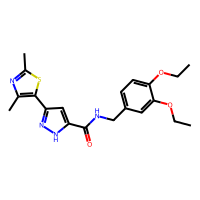
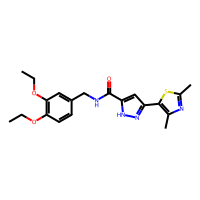
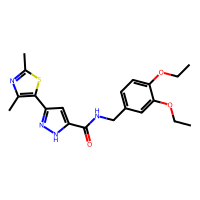
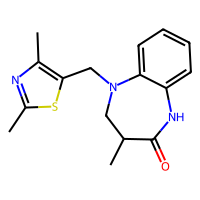
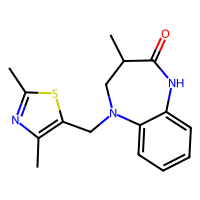
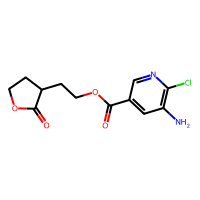
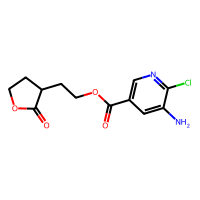
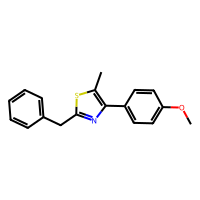
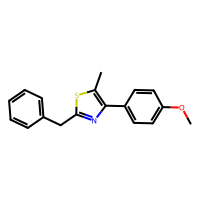
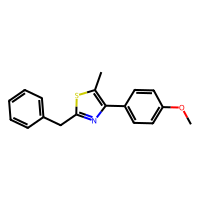

In [35]:
train

In [42]:
sum(train.FPs[0] == train.FPs[6])

8013

In [62]:
print(smiles)

['c1cc(OCC)c(OCC)cc1CNC(c1cc(-c2sc(C)nc2C)n[nH]1)=O']


In [119]:
import numpy as np
ans = []
sme = SmilesEnumerator.SmilesEnumerator(pad=200)
sme.fit(train['SMILES'])
for i in range(len(train)):
    smiles = np.array([train.loc[i,'SMILES']])
    ans.append(sme.transform(smiles))


# sme.fit(smiles)
# print(sme.charset)
# print(sme.pad)

KeyError: '7'

In [114]:
test = pd.read_csv('./test.csv')
ans_test = []
def tp(smile):
    if 'P' in smile:
        return smile.replace('P','')
    else:
        return smile
test['SMILES'] = test['SMILES'].apply(tp)
for i in range(len(train)):
    smiles = np.array([test.loc[i,'SMILES']])
    ans_test.append(sme.transform(smiles))

[19:57:40] Explicit valence for atom # 2 O, 5, is greater than permitted


AttributeError: 'NoneType' object has no attribute 'GetNumAtoms'

In [118]:
test.loc[348,'SMILES']

'CCO(=O)(Cc1ccc(-c2ccccc2OC)cn1)OCC'

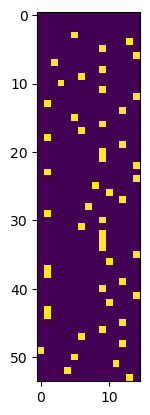

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
vect = sme.transform(smiles)
plt.imshow(vect[0])

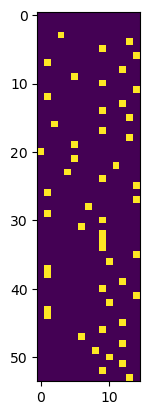

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
vect = sme.transform(smiles)
plt.imshow(vect[0])

In [47]:
vect

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 